In [1]:
import numpy as np
import pandas as pd

import sys
import string
from io import StringIO
import re

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import pysam

In [2]:
# From SAM/BAM files
# Each CIGAR string is a series of operations and lengths,and each operation is followed by the length of the operation.
# a CIGAR string 10M2I3D represents an alignment with 10 matches, 2 insertions, and 3 deletions. 
def cigarToList(cigar):
    ''' Parse CIGAR string into a list of CIGAR operations.  For more
        info on CIGAR operations, see SAM spec:
        http://samtools.sourceforge.net/SAMv1.pdf '''
    ret, i = [], 0
    op_map = {'M':0, # match or mismatch
              '=':0, # match
              'X':0, # mismatch
              'I':1, # insertion in read w/r/t reference
              'D':2, # deletion in read w/r/t reference
              'N':3, # long gap due e.g. to splice junction
              'S':4, # soft clipping due e.g. to local alignment(clipped sequence present in SEQ)
              'H':5, # hard clipping (clipped sequence not present in SEQ)
              'P':6} # padding
    # Seems like = and X together are strictly more expressive than M.
    # Why not just have = and X and get rid of M?  Space efficiency,
    # mainly.  The titans discuss: http://www.biostars.org/p/17043/
    while i < len(cigar):
        run = 0
        while i < len(cigar) and cigar[i].isdigit():
            # parse one more digit of run length
            run *= 10
            run += int(cigar[i])
            i += 1
        assert i < len(cigar)
        # parse cigar operation
        op = cigar[i]
        i += 1
        assert op in op_map
        # append to result
        ret.append([op_map[op], run])#op_map[op] maps the CIGAR operation character to its integer code, run is the parsed run length for the operation.
    return ret

In [3]:
def mdzToList(md):
    ''' Parse MD:Z string into a list of operations, where 0=match,
        1=mismatch, 2=read gap. '''
    i = 0;
    ret = [] # list of (op, run, str) tuples
    while i < len(md):
        if md[i].isdigit(): # If the current character is a digit, it indicates a stretch of matches, and return the length of match
            run = 0
            while i < len(md) and md[i].isdigit():
                run *= 10
                run += int(md[i])
                i += 1 # skip over digit
            if run > 0:
                ret.append([0, run, ""]) # where assign 0 to match
        elif md[i].isalpha(): # If the current character is an alphabet letter, it indicates a stretch of mismatches,and return the length of mismatch
            mmstr = ""
            while i < len(md) and md[i].isalpha():
                mmstr += md[i]
                i += 1
            assert len(mmstr) > 0
            ret.append([1, len(mmstr), mmstr]) # where assign 1 to mismatch
        elif md[i] == "^": # If the current character is '^', it indicates a read gap, and return the length of gap
            i += 1 # skip over ^
            refstr = ""
            while i < len(md) and md[i].isalpha():
                refstr += md[i]
                i += 1 # skip over inserted character
            assert len(refstr) > 0
            ret.append([2, len(refstr), refstr]) # where assign 2 to gap
        else:
            raise RuntimeError('Unexpected character in MD:Z: "%d"' % md[i])
    return ret

In [4]:
def cigarMdzToStacked(seq, cgp, mdp_orig):
    ''' Takes parsed CIGAR and parsed MD:Z, along with the original sequence seq, generates a stacked alignment:
        a pair of strings with gap characters inserted (possibly) and where
        characters at at the same offsets are opposite each other in the
        alignment.  Only knows how to handle CIGAR ops M=XDINSH right now.
    '''
    mdp = mdp_orig[:]
    rds, rfs = [], []
    mdo, rdoff = 0, 0
    for c in cgp:
        op, run = c
        skipping = (op == 4 or op == 5)
        assert skipping or mdo < len(mdp)
        if op == 0: # CIGAR op M, = or X
            # Look for block matches and mismatches in MD:Z string
            mdrun = 0
            runleft = run
            while runleft > 0 and mdo < len(mdp):
                op_m, run_m, st_m = mdp[mdo]
                run_comb = min(runleft, run_m)
                runleft -= run_comb
                assert op_m == 0 or op_m == 1
                rds.append(seq[rdoff:rdoff + run_comb])
                if op_m == 0: # match from MD:Z string
                    rfs.append(seq[rdoff:rdoff + run_comb])
                else: # mismatch from MD:Z string
                    assert len(st_m) == run_comb
                    rfs.append(st_m)
                mdrun += run_comb
                rdoff += run_comb
                # Stretch of matches in MD:Z could span M and I CIGAR ops
                if run_comb < run_m:
                    assert op_m == 0
                    mdp[mdo][1] -= run_comb
                else:
                    mdo += 1
        elif op == 1: # For an insertion operation (op == 1), it adds the inserted sequence to rds and a gap character to rfs.
            rds.append(seq[rdoff:rdoff + run])
            rfs.append("-" * run)
            rdoff += run
        elif op == 2: # For a deletion operation (op == 2), it adds a gap character to rds and the deleted sequence from the MD:Z string to rfs.
            op_m, run_m, st_m = mdp[mdo]
            assert op_m == 2
            assert run == run_m
            assert len(st_m) == run
            mdo += 1
            rds.append("-" * run)
            rfs.append(st_m)
        elif op == 3: # For a long gap due to a splice junction (op == 3), it adds gap characters to both rds and rfs.
            rds.append("-" * run)
            rfs.append("-" * run)
        elif op == 4: # S
            rds.append(seq[rdoff:rdoff + run].lower())
            rfs.append(' ' * run)
            rdoff += run
        elif op == 5: # H
            rds.append('!' * run)
            rfs.append(' ' * run)
        elif op == 6: # P
            raise RuntimeError("Don't know how to handle P in CIGAR")
        else:
            raise RuntimeError('Unexpected CIGAR op: %d' % op)
    assert mdo == len(mdp)
    return ''.join(rds), ''.join(rfs)

In [5]:
data_path = '/Users/haokai/Desktop/Github repository/Processed data/Fig. 4/'

In [6]:
# The edit state of reference_plasmid is 001011011100 
samPath = ['WntR_Rep1.sam','WntR_Rep2.sam','WntR_Rep3.sam','WntR_Control.sam','Reference_plasmid.sam']

In [7]:
# extract relevant information from the SAM file and make stacked alignments
# The line number (c) of the read in the SAM file.
# stacked alignments, [Ref, reads]
#1-based leftmost mapping position of the read on the reference genome.

multi_align = []
not_aligned = []
for p in samPath:
  multi_al = []
  not_al = []
  with open(data_path+p) as fp:
      for c,ln in enumerate(fp):
        if ln[0] != '@':
          qname, flag, rname, pos, mapq, cigar, rnext, \
          pnext, tlen, seq, qual, extras = str.split(ln, '\t', 11)
          MDZ = re.findall('MD:Z:(.*?)\t',extras)
          if len(MDZ) != 1:
            not_al.append([c,len(MDZ)])
          else:
            multi_al.append([c,cigarMdzToStacked(seq, cigarToList(cigar), mdzToList(MDZ[0])),int(pos)])
  multi_align.append(multi_al)
  not_aligned.append(not_al)

In [8]:
BC1_amplicon ='gcctccacggccagaattctaactataacggtcctaaggtagcgaaTGCCCCCTGTGATTCGTCAACATACACGCCCTGATGCAACCCTGTGATTCGTCAACATACACGCCCTGATACTACCCTGTGATTCGTCAACATACACGCCCTGATTTACCCCTGTGATTCGTCAACATACACGCCCTGATCAGACCCTGTGATTCGTCAACATACACGCCCTGATTGTGCCCTGTGATTCGTCAACATACACGCCCTGATGAGCCCCTGTGATTCGTCAACATACACGCCCTGATAGGACCCTGTGATTCGTCAACATACACGCCCTGATATTCCCCTGTGATTCGTCAACATACACGCCCTGATCGAACCCTGTGATTCGTCAACATACACGCCCTGATATAGCCCTGTGATTCGTCAACATACACGCCCTGATAAGGCCCTGTGATTCGTCAACATACACGCCCTGATAACTccctttagtgagggttaattctACCG'
bc1_tag = []
for i in range(12):
  start = 69 + i*35
  end = start + 16
  bc1_tag.append(BC1_amplicon[start:end].upper())

In [9]:
bc1_tag

['ACACGCCCTGATGCAA',
 'ACACGCCCTGATACTA',
 'ACACGCCCTGATTTAC',
 'ACACGCCCTGATCAGA',
 'ACACGCCCTGATTGTG',
 'ACACGCCCTGATGAGC',
 'ACACGCCCTGATAGGA',
 'ACACGCCCTGATATTC',
 'ACACGCCCTGATCGAA',
 'ACACGCCCTGATATAG',
 'ACACGCCCTGATAAGG',
 'ACACGCCCTGATAACT']

In [10]:
samPath

['WntR_Rep1.sam',
 'WntR_Rep2.sam',
 'WntR_Rep3.sam',
 'WntR_Control.sam',
 'Reference_plasmid.sam']

# WntR_Rep1 for Demo

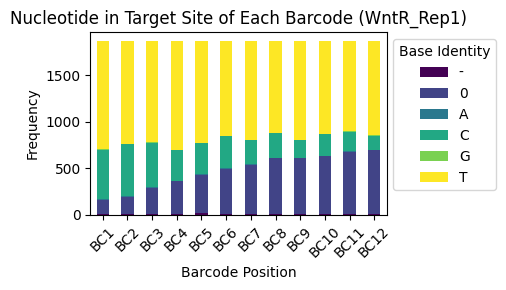

In [56]:
sample = multi_align[0]
base_list = []
for i in range(len(sample)):
    base = []
    for bc in bc1_tag:
        res = re.search(bc, sample[i][1][1])
        if res:
            base.append(sample[i][1][0][res.start() - 1])
        else:
            base.append('0')  # '0' for no match
    base_list.append(base)

# Create DataFrame
Rep1_df = pd.DataFrame(base_list, columns=['BC{}'.format(i) for i in range(1, 13)])

# Compute nucleotide frequency
df_freq_1 = Rep1_df.apply(pd.Series.value_counts).fillna(0)  # Fill missing values with 0

# Plot stacked bar chart
df_freq_1.T.plot(kind='bar', stacked=True, colormap='viridis', figsize=(5, 3))

# Customize labels
plt.xlabel('Barcode Position')
plt.ylabel('Frequency')
plt.title('Nucleotide in Target Site of Each Barcode (WntR_Rep1)')
plt.xticks(rotation=45)  # Rotate for readability
plt.legend(title='Base Identity', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

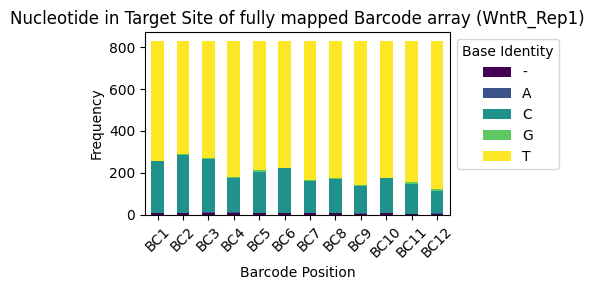

In [11]:
sample = multi_align[0]
base_list = []
for i in range(len(sample)):
    base = []
    for bc in bc1_tag:
        res = re.search(bc, sample[i][1][1])
        if res:
            base.append(sample[i][1][0][res.start() - 1])
        else:
            base.append('0')  # '0' for no match
    base_list.append(base)

# Create DataFrame
Rep1_df = pd.DataFrame(base_list, columns=['BC{}'.format(i) for i in range(1, 13)])

# remove samples that are not fully mapped
Rep1_df = Rep1_df.loc[~Rep1_df.isin(['0']).any(axis=1)].copy()

# Compute nucleotide frequency
df_freq_1 = Rep1_df.apply(pd.Series.value_counts).fillna(0)  # Fill missing values with 0

# Plot stacked bar chart
df_freq_1.T.plot(kind='bar', stacked=True, colormap='viridis', figsize=(5, 3))

# Customize labels
plt.xlabel('Barcode Position')
plt.ylabel('Frequency')
plt.title('Nucleotide in Target Site of fully mapped Barcode array (WntR_Rep1)')
plt.xticks(rotation=45)  # Rotate for readability
plt.legend(title='Base Identity', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [12]:
Rep1_df

,BC1,BC2,BC3,BC4,BC5,BC6,BC7,BC8,BC9,BC10,BC11,BC12
4,T,C,C,C,C,C,C,T,C,T,C,T
8,T,C,C,T,T,G,G,C,T,T,T,T
10,T,T,T,T,T,T,T,T,T,T,T,G
12,C,C,C,T,C,T,T,T,T,T,T,T
14,C,C,C,C,C,C,T,T,T,T,T,T
...,...,...,...,...,...,...,...,...,...,...,...,...
1861,T,T,T,T,T,T,T,T,T,T,T,T
1862,T,T,T,T,T,T,T,T,T,T,T,T
1864,T,T,T,C,T,T,T,T,T,T,T,T
1865,T,C,T,C,T,T,T,C,C,C,C,T


In [13]:
df_freq_1

,BC1,BC2,BC3,BC4,BC5,BC6,BC7,BC8,BC9,BC10,BC11,BC12
-,8,8,6,6,7.0,6,6,8,4,9,2,4
A,2,1,6,6,0.0,2,3,1,3,1,3,5
C,246,278,253,163,199.0,213,154,161,128,164,144,106
G,2,3,4,4,6.0,4,3,4,5,1,7,6
T,571,539,560,650,617.0,604,663,655,689,654,673,708


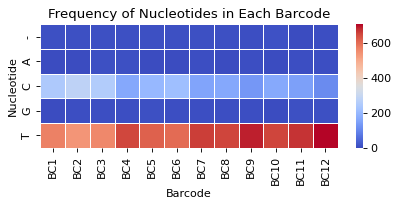

In [14]:
plt.figure(figsize=(6, 2), dpi=80)
df_freq_1.fillna(0, inplace=True)
sns.heatmap(df_freq_1, annot=False, cmap='coolwarm', fmt='.0f', linewidths=0.5)
plt.xlabel('Barcode')
plt.ylabel('Nucleotide')
plt.title('Frequency of Nucleotides in Each Barcode')
plt.show()

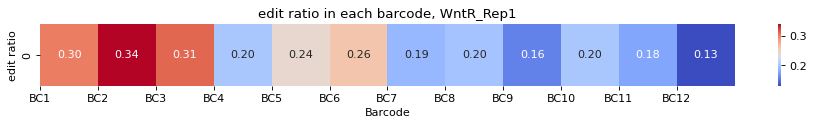

In [15]:
# Calculate C/(C+T) for each barcode
ratio_df_1 = df_freq_1.loc['C'] / (df_freq_1.loc['C'] + df_freq_1.loc['T'])

# Plot the heatmap
plt.figure(figsize=(14, 1), dpi=80)
sns.heatmap(ratio_df_1.to_frame().T, cmap='coolwarm', annot=True, fmt='.2f')
plt.xlabel('Barcode')
plt.ylabel('edit ratio')
plt.title('edit ratio in each barcode, WntR_Rep1')
plt.xticks(ticks=range(len(ratio_df_1)), labels=ratio_df_1.index)
plt.show()

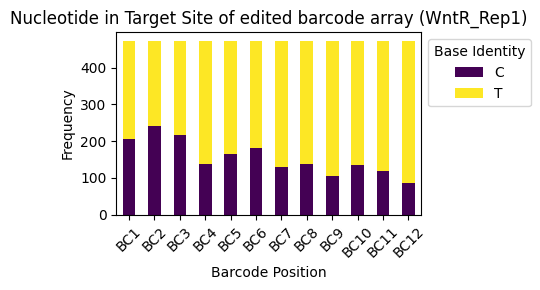

In [16]:
sample = multi_align[0]
base_list = []
for i in range(len(sample)):
    base = []
    for bc in bc1_tag:
        res = re.search(bc, sample[i][1][1])
        if res:
            base.append(sample[i][1][0][res.start() - 1])
        else:
            base.append('0')  # '0' for no match
    base_list.append(base)

# consider the nucleotide in target Site of each barcode only mapped to 'T' or 'C' 
TC_df = Rep1_df.loc[~Rep1_df.isin(['-','A','G']).any(axis=1)].copy()

# Filter out rows where all values are 'T', whcih are unedited barcode arrays
all_T = TC_df.apply(lambda row: all(row == 'T'), axis=1)
edited_df_1 = TC_df[~all_T]

# Compute nucleotide frequency
df_freq_e1 = edited_df_1.apply(pd.Series.value_counts).fillna(0)  # Fill missing values with 0

# Plot stacked bar chart
df_freq_e1.T.plot(kind='bar', stacked=True, colormap='viridis', figsize=(5, 3))

# Customize labels
plt.xlabel('Barcode Position')
plt.ylabel('Frequency')
plt.title('Nucleotide in Target Site of edited barcode array (WntR_Rep1)')
plt.xticks(rotation=45)  # Rotate for readability
plt.legend(title='Base Identity', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [17]:
edited_df_1

,BC1,BC2,BC3,BC4,BC5,BC6,BC7,BC8,BC9,BC10,BC11,BC12
4,T,C,C,C,C,C,C,T,C,T,C,T
12,C,C,C,T,C,T,T,T,T,T,T,T
14,C,C,C,C,C,C,T,T,T,T,T,T
15,T,C,T,T,C,T,T,C,T,T,C,T
23,T,T,T,T,T,T,T,C,T,C,T,T
...,...,...,...,...,...,...,...,...,...,...,...,...
1848,T,T,C,T,T,T,T,T,T,T,T,T
1857,C,C,T,T,T,T,C,T,T,T,T,T
1864,T,T,T,C,T,T,T,T,T,T,T,T
1865,T,C,T,C,T,T,T,C,C,C,C,T


In [18]:
# Replace 'T' with 0 and 'C' with 1
display_df_1 = edited_df_1.replace({'T': 0, 'C': 1})

# Calculate the count of '1's in each row
display_df_1['edits'] = display_df_1.apply(lambda row: row.eq(1).sum(), axis=1)

# Rank the rows in ascending order based on the count of '1's
display_df_1['rank'] = display_df_1['edits'].rank(ascending=True, method='min')

# Sort the DataFrame by rank
display_df_1.sort_values(by='rank', inplace=True)

# Display the DataFrame
display_df_1

,BC1,BC2,BC3,BC4,BC5,BC6,BC7,BC8,BC9,BC10,BC11,BC12,edits,rank
1559,0,0,1,0,0,0,0,0,0,0,0,0,1,1.0
445,0,0,0,0,0,0,1,0,0,0,0,0,1,1.0
1760,0,0,0,0,0,0,1,0,0,0,0,0,1,1.0
969,0,0,0,0,1,0,0,0,0,0,0,0,1,1.0
995,1,0,0,0,0,0,0,0,0,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,1,1,1,1,1,1,1,1,1,1,1,1,12,461.0
447,1,1,1,1,1,1,1,1,1,1,1,1,12,461.0
1733,1,1,1,1,1,1,1,1,1,1,1,1,12,461.0
1048,1,1,1,1,1,1,1,1,1,1,1,1,12,461.0


In [19]:
# Calculate the count of rows for each unique 'edits' value
edits_1 = display_df_1['edits'].value_counts().sort_index()

# Convert the Series to a DataFrame for better readability if needed
edits_1 = edits_1.reset_index()
edits_1.columns = ['edits', 'count']

# Display the counts
edits_1

,edits,count
0,1,121
1,2,92
2,3,67
3,4,38
4,5,27
5,6,30
6,7,24
7,8,18
8,9,16
9,10,8


In [20]:
def leftmost_n(row, n):
    count = 0
    for i, val in enumerate(row):
        if val == 1:
            count += 1
            if count == n:
                return i
    return len(row)

# Identify the leftmost, second leftmost, third leftmost, etc. occurrences of '1' in each row
for n in range(1, display_df_1['edits'].max() + 1):
    display_df_1[f'leftmost_{n}'] = display_df_1.apply(lambda row: leftmost_n(row[:-2], n), axis=1)

# Create a list of columns for sorting
sort_columns = ['edits'] + [f'leftmost_{n}' for n in range(1, display_df_1['edits'].max() + 1)]

# Sort the DataFrame by 'edits' and the leftmost occurrences
display_df_1.sort_values(by=sort_columns, inplace=True)

# Display the sorted DataFrame
len(display_df_1)

472

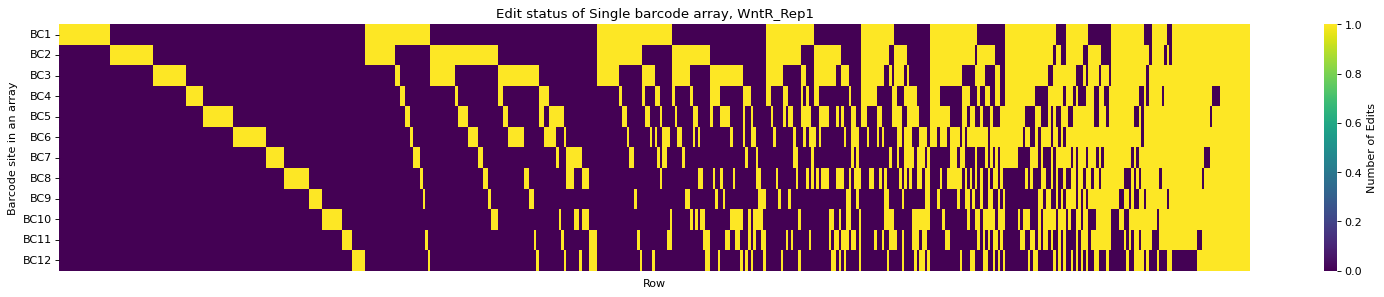

In [21]:
# Select the columns from BC1 to BC12 for the heatmap
heatmap_data = display_df_1.iloc[:, :12]

# Transpose the data for the heatmap
heatmap_data = heatmap_data.T

# Plot the heatmap
plt.figure(figsize=(24, 4), dpi=80)
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Number of Edits'}, xticklabels=False, yticklabels=True)
plt.xlabel('Row')
plt.ylabel('Barcode site in an array')
plt.title('Edit status of Single barcode array, WntR_Rep1')
plt.show()

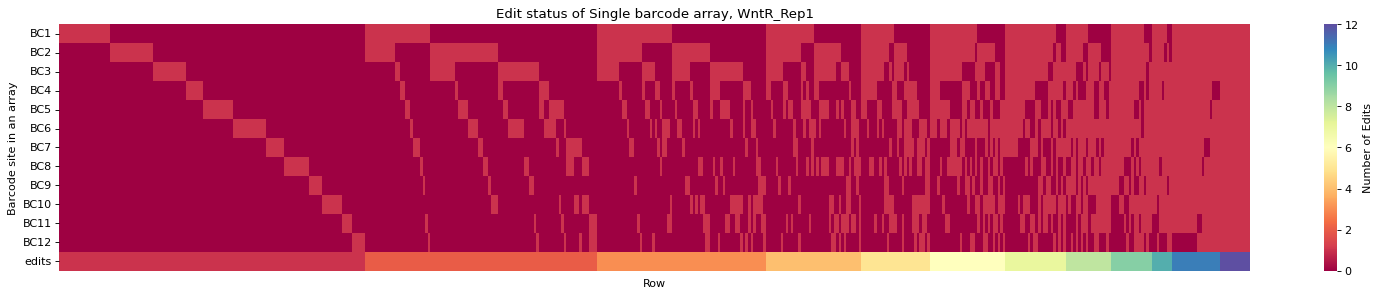

In [22]:
# Select the columns from BC1 to BC12 for the heatmap
heatmap_data = display_df_1.iloc[:, :13]

# Transpose the data for the heatmap
heatmap_data = heatmap_data.T

# Plot the heatmap
plt.figure(figsize=(24, 4), dpi=80)
sns.heatmap(heatmap_data, cmap='Spectral', cbar_kws={'label': 'Number of Edits'}, xticklabels=False, yticklabels=True)
plt.xlabel('Row')
plt.ylabel('Barcode site in an array')
plt.title('Edit status of Single barcode array, WntR_Rep1')
plt.show()

# Notes,
* The unique 4bp sequences flanking each barcode were used to identify the position of barcodes in the array. The reads matched to all the barcode positions are consided as the fully mapped reads.
* Rep1_df, Rep2_df, Rep3_df and ctrl_df are extracted fully mapped reads from WntR_Rep1, WntR_Rep2, WntR_Rep3 and WntR_Control
* edited_df_1, edited_df_2 and edited_df_3 are extracted edited mapped reads from WntR_Rep1, WntR_Rep2 and WntR_Rep3
* ratio_df_1, ratio_df_2, ratio_df_3, ratio_df_ctrl and ratio_df_p34 are calculated edit rate for each targeted barcode position from WntR_Rep1, WntR_Rep2, WntR_Rep3, WntR_Control and Reference_plasmid


In [482]:
Rep1_df['Replicate'] = 'Rep1'
Rep2_df['Replicate'] = 'Rep2'
Rep3_df['Replicate'] = 'Rep3'
ctrl_df['Replicate'] = 'Control'

# Concatenate along rows (axis=0)
reads_df = pd.concat([Rep1_df, Rep2_df, Rep3_df, ctrl_df], axis=0, ignore_index=True)

# Display the combined DataFrame
reads_df

,BC1,BC2,BC3,BC4,BC5,BC6,BC7,BC8,BC9,BC10,BC11,BC12,Replicate
0,T,C,C,C,C,C,C,T,C,T,C,T,Rep1
1,T,C,C,T,T,G,G,C,T,T,T,T,Rep1
2,T,T,T,T,T,T,T,T,T,T,T,G,Rep1
3,C,C,C,T,C,T,T,T,T,T,T,T,Rep1
4,C,C,C,C,C,C,T,T,T,T,T,T,Rep1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3924,T,T,T,T,T,T,T,T,T,T,T,T,Control
3925,T,T,T,T,T,T,T,T,T,T,T,T,Control
3926,T,T,T,T,T,T,T,T,T,T,T,T,Control
3927,T,T,T,T,T,T,T,T,T,T,T,T,Control


In [483]:
reads_df.to_csv(data_path + 'Fully mapped barcode array_Wnt_BC1_3 x Replicates_Amplicon_seq.csv', index=False)

In [485]:
Fully_mapped_reads_number = reads_df.groupby('Replicate', as_index=False).size()
Fully_mapped_reads_number

,Replicate,size
0,Control,1178
1,Rep1,829
2,Rep2,985
3,Rep3,937


In [486]:
edited_df_1['Replicate'] = 'Rep1'
edited_df_2['Replicate'] = 'Rep2'
edited_df_3['Replicate'] = 'Rep3'
edited_df_ctrl['Replicate'] = 'Control'

# Concatenate along rows (axis=0)
edited_df = pd.concat([edited_df_1, edited_df_2, edited_df_3, edited_df_ctrl], axis=0, ignore_index=True)

# Display the combined DataFrame
edited_df

/var/folders/gn/s03fpkm91rs2n_qpydhyntfh0000gn/T/ipykernel_19728/1959560720.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edited_df_ctrl['Replicate'] = 'Control'


,BC1,BC2,BC3,BC4,BC5,BC6,BC7,BC8,BC9,BC10,BC11,BC12,Replicate
0,T,C,C,C,C,C,C,T,C,T,C,T,Rep1
1,C,C,C,T,C,T,T,T,T,T,T,T,Rep1
2,C,C,C,C,C,C,T,T,T,T,T,T,Rep1
3,T,C,T,T,C,T,T,C,T,T,C,T,Rep1
4,T,T,T,T,T,T,T,C,T,C,T,T,Rep1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,T,T,T,T,T,T,T,C,T,T,T,T,Control
1490,T,T,T,C,T,T,T,T,C,T,T,T,Control
1491,T,T,T,T,T,C,T,T,T,T,T,T,Control
1492,T,T,T,T,T,T,C,T,T,T,T,T,Control


In [487]:
edited_reads_number = reads_df.groupby('Replicate', as_index=False).size()
edited_reads_number

,Replicate,size
0,Control,1178
1,Rep1,829
2,Rep2,985
3,Rep3,937


In [488]:
edited_df.to_csv(data_path + 'Edited barcode array_Wnt_BC1_3 x Replicates_Amplicon_Seq.csv', index=False)

In [505]:
# Replace 'T' with 0 and 'C' with 1
display_df = edited_df.loc[edited_df['Replicate'] != 'Control'].replace({'T': 0, 'C': 1})

# Calculate the count of '1's in each row
display_df['edits'] = display_df.apply(lambda row: row.eq(1).sum(), axis=1)

# Rank the rows in ascending order based on the count of '1's
display_df['rank'] = display_df['edits'].rank(ascending=True, method='min')

# Sort the DataFrame by rank
display_df.sort_values(by='rank', inplace=True)

# Display the DataFrame
display_df = display_df.iloc[:, :14]

# Swap 'Replicate' and 'edits' columns
display_df = display_df[[col for col in display_df.columns if col != 'Replicate' and col != 'edits'] + ['edits', 'Replicate']]

display_df

,BC1,BC2,BC3,BC4,BC5,BC6,BC7,BC8,BC9,BC10,BC11,BC12,edits,Replicate
408,0,1,0,0,0,0,0,0,0,0,0,0,1,Rep1
1073,0,0,0,0,1,0,0,0,0,0,0,0,1,Rep3
1072,0,1,0,0,0,0,0,0,0,0,0,0,1,Rep3
466,0,0,1,0,0,0,0,0,0,0,0,0,1,Rep1
467,0,0,1,0,0,0,0,0,0,0,0,0,1,Rep1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,1,1,1,1,1,1,1,1,1,1,1,1,12,Rep2
962,1,1,1,1,1,1,1,1,1,1,1,1,12,Rep2
193,1,1,1,1,1,1,1,1,1,1,1,1,12,Rep1
774,1,1,1,1,1,1,1,1,1,1,1,1,12,Rep2


In [519]:
display_df.to_csv(data_path + 'Edit status of Single barcode array_Wnt_BC1_3 x Replicates.csv', index=False)

In [549]:
# Concatenate along rows (axis=0)
freq_df = pd.concat([ratio_df_1, ratio_df_2, ratio_df_3, ratio_df_ctrl, ratio_df_p34],axis=1)
freq_df.columns = ['Rep1','Rep2','Rep3','control','reference_plasmid']
# Display the combined DataFrame
freq_df

,Rep1,Rep2,Rep3,control,reference_plasmid
BC1,0.301102,0.235113,0.183983,0.051724,0.005212
BC2,0.340269,0.284394,0.219222,0.068966,0.013708
BC3,0.311193,0.258993,0.179266,0.137931,0.994179
BC4,0.200492,0.185376,0.142703,0.103448,0.014964
BC5,0.243873,0.220408,0.166124,0.068966,0.993490
BC6,0.260710,0.203093,0.152928,0.103448,0.989644
BC7,0.188494,0.152577,0.123922,0.068966,0.013699
BC8,0.197304,0.167523,0.136808,0.103448,0.994179
BC9,0.156671,0.124871,0.105832,0.172414,0.992208
BC10,0.200489,0.148454,0.129590,0.137931,0.992223


In [550]:
freq_df.to_csv(data_path + 'Edit rate for each targeted barcode position_Wnt_BC1_3 x Replicates.csv', index=False)